In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import utils


In [2]:
players_info_list = utils.get_dataframes_csv_file('../scraping/csv/players_infos')
players_stats_list = utils.get_dataframes_csv_file('../scraping/csv/players_stats')

In [3]:
players_stats_list_summer_league = []
players_stats_list_playoffs = []
players_stats_list_regular_season = []
players_stats_list_preseason = []

for df in players_stats_list:
    year = df['Title'].iloc[0].split(' ')[1]

    if year == '2023-2024':
        continue

    season_type = df['Title'].iloc[0].split(' ')[2]
    
    # Ajouter les données au dictionnaire approprié
    if season_type == 'Summer_League':
        players_stats_list_summer_league.append(df)
    elif season_type == 'Playoffs':
        players_stats_list_playoffs.append(df)
    elif season_type == 'Regular_Season':
        players_stats_list_regular_season.append(df)
    elif season_type == 'Preseason':
        players_stats_list_preseason.append(df)

### Ajouter les informations de chaque joueurs dans les data des stats pour les stats des saisons régulières 

In [4]:
players_df_list = []

for stats_df in players_stats_list_regular_season:
    players_list = []

    for index, row in stats_df.iterrows():
        # Obtention du titre du DataFrame de statistiques
        title = row['Title']

        # Obtention de l'année et du type de saison à partir du titre
        year_season = title.split(' ')[1]

        # Obtention du nom du joueur à partir de la colonne 'Player'
        player_name = row['Player']

        # Recherche du DataFrame correspondant dans players_info_list
        info_df = None
        for info_df in players_info_list:
            info_title = info_df['Title'].iloc[0]
            if year_season in info_title:
                break

        if info_df is not None:
            # Recherche de la ligne correspondante au joueur dans le DataFrame info_df
            player_info = info_df[info_df['Player'] == player_name]

            if not player_info.empty:
                # Création d'une liste contenant les informations du joueur
                player_data = [
                    player_name,
                    player_info['Pos'].iloc[0],
                    player_info['HT'].iloc[0],
                    player_info['WT'].iloc[0],
                    player_info['Age'].iloc[0],
                    player_info['Teams'].iloc[0],
                    row['GP'],
                    player_info['YOS'].iloc[0],
                    player_info['Pre-Draft Team'].iloc[0],
                    player_info['Draft Status'].iloc[0],
                    player_info['Nationality'].iloc[0],
                    row['Team'],
                    row['MIN'],
                    row['PTS'],
                    row['FGM'],
                    row['FGA'],
                    row['FG%'],
                    row['3PM'],
                    row['3PA'],
                    row['3P%'],
                    row['FTM'],
                    row['FTA'],
                    row['FT%'],
                    row['ORB'],
                    row['DRB'],
                    row['REB'],
                    row['AST'],
                    row['STL'],
                    row['BLK'],
                    row['TOV'],
                    row['PF']
                ]

                players_list.append(player_data)
            else:
                # Si aucune correspondance n'est trouvée, ajouter des zéros pour chaque colonne
                player_data = [
                    player_name,
                    0,
                    0,
                    0,
                    0,
                    0,
                    row['GP'],
                    0,
                    0,
                    0,
                    0,
                    row['Team'],
                    row['MIN'],
                    row['PTS'],
                    row['FGM'],
                    row['FGA'],
                    row['FG%'],
                    row['3PM'],
                    row['3PA'],
                    row['3P%'],
                    row['FTM'],
                    row['FTA'],
                    row['FT%'],
                    row['ORB'],
                    row['DRB'],
                    row['REB'],
                    row['AST'],
                    row['STL'],
                    row['BLK'],
                    row['TOV'],
                    row['PF']
                ]

                players_list.append(player_data)

    # Création du DataFrame à partir de la liste des données des joueurs
    columns = ['Player', 'Pos', 'HT', 'WT', 'Age', 'Teams', 'GP', 'YOS', 'Pre-Draft Team', 'Draft Status',
            'Nationality', 'Team', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM',
            'FTA', 'FT%', 'ORB', 'DRB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']

    players_df = pd.DataFrame(players_list, columns=columns)

    players_df_list.append(players_df)

In [5]:
# Fonction de conversion de pieds et pouces en mètres
def convert_to_meters(ht : str):
    if ht == '' or ht == 0:
        return None

    feet, inches = ht.split('-')
    if(inches == ''):
        if(feet == ''):
            return None
        inches = '0'

    total_inches = int(feet) * 12 + int(inches)
    meters = total_inches * 0.0254
    return meters

# Appliquer la fonction de conversion à la colonne "HT" pour obtenir la taille en mètres a tout nos données
for df in players_df_list:
    df['HT'] = df['HT'].apply(convert_to_meters)

### Analayser corrélation des variables 

In [6]:
# Concaténation des DataFrames en un seul DataFrame global
combined_df = pd.concat(players_df_list, ignore_index=True)

# Sélectionnez les variables d'intérêt pour l'analyse de corrélation. Supprimez les colonnes qui ne sont pas pertinentes pour l'analyse PCA :
variables_of_interest = ['HT', 'WT', 'Age', 'GP', 'YOS', 'MIN',
                        'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%',
                        'ORB', 'DRB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']

selected_df = combined_df[variables_of_interest]

In [7]:
combined_df.columns

Index(['Player', 'Pos', 'HT', 'WT', 'Age', 'Teams', 'GP', 'YOS',
       'Pre-Draft Team', 'Draft Status', 'Nationality', 'Team', 'MIN', 'PTS',
       'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB',
       'DRB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF'],
      dtype='object')

In [8]:
# Rendre toutes les données numérique 
non_numeric_columns = selected_df.select_dtypes(exclude=[np.number]).columns

for column in non_numeric_columns:
    selected_df[column] = selected_df[column].apply(lambda x: float(x.replace(',', '')) if isinstance(x, str) and x != '-' else None if x == '-' else x)

C:\Users\Kadem\AppData\Local\Temp\ipykernel_14056\4242139873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df[column] = selected_df[column].apply(lambda x: float(x.replace(',', '')) if isinstance(x, str) and x != '-' else None if x == '-' else x)


In [9]:
# Changer les stats de nombre total en stats par minute joué 
total_stats = ['PTS', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'ORB', 'DRB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']
for stat in total_stats:
    new_col_name = stat + 'perMIN'
    selected_df[new_col_name] = selected_df[stat] / selected_df['MIN'].apply(lambda x: 0 if x == 0 else x)

    
# Supprimer les anciennes colonnes
selected_df.drop(total_stats, axis=1, inplace=True)

C:\Users\Kadem\AppData\Local\Temp\ipykernel_14056\2812451126.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df[new_col_name] = selected_df[stat] / selected_df['MIN'].apply(lambda x: 0 if x == 0 else x)
C:\Users\Kadem\AppData\Local\Temp\ipykernel_14056\2812451126.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df[new_col_name] = selected_df[stat] / selected_df['MIN'].apply(lambda x: 0 if x == 0 else x)
C:\Users\Kadem\AppData\Local\Temp\ipykernel_14056\2812451126.py:5: SettingWithCo

In [10]:
selected_df.columns

Index(['HT', 'WT', 'Age', 'GP', 'YOS', 'MIN', 'FG%', '3P%', 'FT%', 'PTSperMIN',
       'FGMperMIN', 'FGAperMIN', '3PMperMIN', '3PAperMIN', 'FTMperMIN',
       'FTAperMIN', 'ORBperMIN', 'DRBperMIN', 'REBperMIN', 'ASTperMIN',
       'STLperMIN', 'BLKperMIN', 'TOVperMIN', 'PFperMIN'],
      dtype='object')

##### Matrice de coorélation 

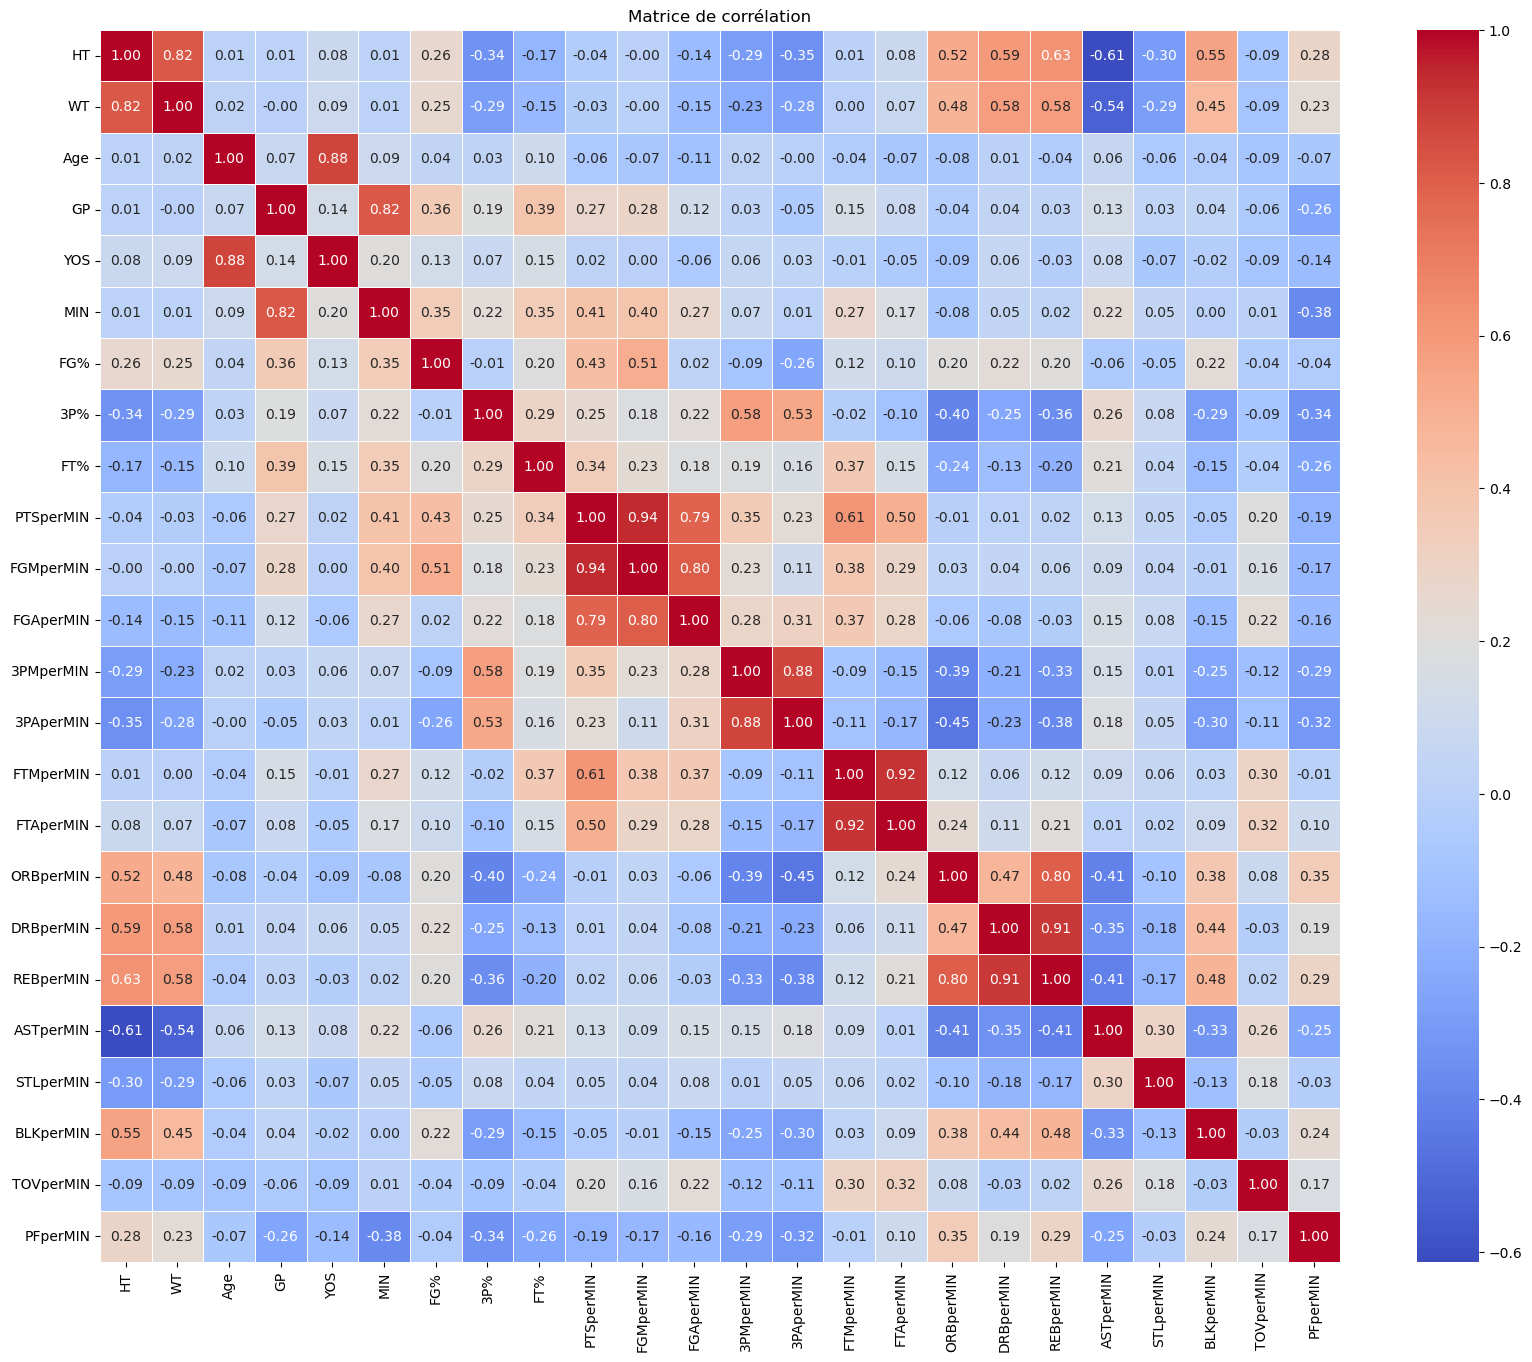

In [11]:
correlation_matrix = selected_df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

##### Analyse PCA

In [12]:
selected_df

,HT,WT,Age,GP,YOS,MIN,FG%,3P%,FT%,PTSperMIN,...,FTMperMIN,FTAperMIN,ORBperMIN,DRBperMIN,REBperMIN,ASTperMIN,STLperMIN,BLKperMIN,TOVperMIN,PFperMIN
0,2.1082,255.0,29.0,80,8,2286.0,0.469,0.000,0.662,0.337270,...,0.057305,0.086614,0.077428,0.190726,0.268154,0.038058,0.025372,0.030184,0.043745,0.109799
1,2.0574,205.0,19.0,3,0,27.0,0.273,0.000,1.000,0.259259,...,0.037037,0.037037,0.000000,0.037037,0.037037,0.111111,0.148148,0.000000,0.111111,0.074074
2,2.0066,260.0,25.0,7,5,291.0,0.496,0.412,0.922,0.591065,...,0.161512,0.175258,0.027491,0.127148,0.154639,0.075601,0.041237,0.020619,0.058419,0.092784
3,2.0320,221.0,24.0,3,2,40.0,0.417,0.000,0.000,0.250000,...,0.000000,0.000000,0.050000,0.100000,0.150000,0.000000,0.100000,0.000000,0.050000,0.150000
4,2.1590,245.0,26.0,45,3,714.0,0.433,0.000,0.576,0.246499,...,0.047619,0.082633,0.113445,0.194678,0.308123,0.023810,0.011204,0.054622,0.051821,0.109244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24024,1.9558,205.0,22.0,82,1,3286.0,0.428,0.364,0.875,0.487523,...,0.104078,0.118990,0.038649,0.084601,0.123250,0.108338,0.033780,0.003652,0.080037,0.074254
24025,1.8542,185.0,24.0,60,2,1298.0,0.428,0.375,0.784,0.375963,...,0.061633,0.078582,0.013097,0.099384,0.112481,0.161017,0.053929,0.008475,0.086287,0.075501
24026,2.0574,225.0,21.0,82,1,2950.0,0.485,0.412,0.784,0.620000,...,0.170169,0.216949,0.076949,0.120000,0.196949,0.072203,0.030169,0.025763,0.087119,0.068136
24027,1.9812,223.0,23.0,59,0,959.0,0.403,0.211,0.672,0.392075,...,0.087591,0.130344,0.045881,0.075078,0.120959,0.053180,0.036496,0.013556,0.067779,0.084463


In [13]:
is_inf = np.isinf(selected_df)
is_nan = np.isnan(selected_df)
selected_df = selected_df.replace([np.inf, -np.inf], np.nan)  # Remplacer les infinies par NaN
selected_df = selected_df.replace(np.nan, None)  # Remplacer les NaN par None

# Normalisation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_df)

In [14]:
s = scaled_data
is_null = np.isnan(s)

# 2. Traiter les valeurs manquantes
s_filled = np.where(is_null, 0, s)

# 3. Effectuer la PCA
pca = PCA()
pca.fit(s_filled)

PCA()

[2.17742908e-01 1.81452843e-01 1.05601041e-01 7.95995454e-02
 6.84706735e-02 4.92431341e-02 4.13016607e-02 3.53295417e-02
 2.99873285e-02 2.87653399e-02 2.79271472e-02 2.53103461e-02
 2.51104765e-02 1.91803376e-02 1.69637290e-02 1.53987576e-02
 7.97561808e-03 6.52325562e-03 5.14181599e-03 4.73581662e-03
 4.02884574e-03 2.31615269e-03 1.83351379e-03 6.01716336e-05] 

variance cumulative : 
 [0.21774291 0.39919575 0.50479679 0.58439634 0.65286701 0.70211014
 0.74341181 0.77874135 0.80872868 0.83749402 0.86542116 0.89073151
 0.91584199 0.93502232 0.95198605 0.96738481 0.97536043 0.98188368
 0.9870255  0.99176132 0.99579016 0.99810631 0.99993983 1.        ]


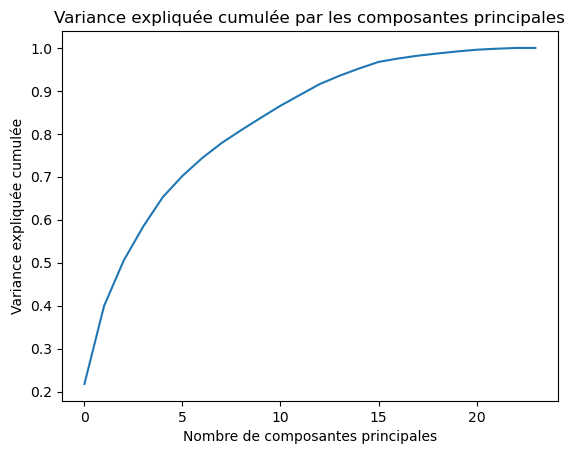

In [20]:
explained_variance = pca.explained_variance_ratio_

# Calculer la variance expliquée cumulée
explained_variance_cumulative = np.cumsum(explained_variance)

print(explained_variance,'\n')

print('variance cumulative : \n',explained_variance_cumulative)
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée par les composantes principales')
plt.show()

On peut prendre 13 composantes pour capturer 90% de la variance

In [32]:
# Nombre de composantes principales à prendre
k = 13

# Instanciation de l'objet PCA
pca = PCA(n_components=k)

# Réduction de dimensionnalité en utilisant les composantes principales
data_reduced = pca.fit_transform(s_filled)

# Analyse des charges des composantes principales
component_loadings = pca.components_

# Affichage des charges (contribution de chaque variable) des variables pour chaque composante principale
for i, component in enumerate(component_loadings):
    print(f"\nComposante principale {i+1}:")
    for j, variable in enumerate(component):
        print(f"{selected_df.columns[j]}: {variable}")


Composante principale 1:
HT: -0.34444973245350496
WT: -0.3193750960533657
Age: 0.02133419115200783
GP: 0.10626796323903627
YOS: 0.030885271875147887
MIN: 0.13819928972295925
FG%: -0.04230697549915057
3P%: 0.2324726986560307
FT%: 0.19812114783613544
PTSperMIN: 0.1803485574159614
FGMperMIN: 0.14596000200875148
FGAperMIN: 0.1905972651512679
3PMperMIN: 0.22116502360327062
3PAperMIN: 0.22849526493965436
FTMperMIN: 0.0641147373676869
FTAperMIN: -0.0030747336741691767
ORBperMIN: -0.28438663510290857
DRBperMIN: -0.26418147839272516
REBperMIN: -0.3253521397203122
ASTperMIN: 0.2821738624329612
STLperMIN: 0.11266211869099729
BLKperMIN: -0.23782050619334724
TOVperMIN: 0.026409334525124367
PFperMIN: -0.2257732711105373

Composante principale 2:
HT: 0.15942435205287495
WT: 0.15092697072163477
Age: -0.009069233979984964
GP: 0.24384999194364312
YOS: 0.04364761975513696
MIN: 0.290666388200982
FG%: 0.2782061889226798
3P%: 0.0031368248491980993
FT%: 0.17343685181087776
PTSperMIN: 0.4040390582982442
FGMp

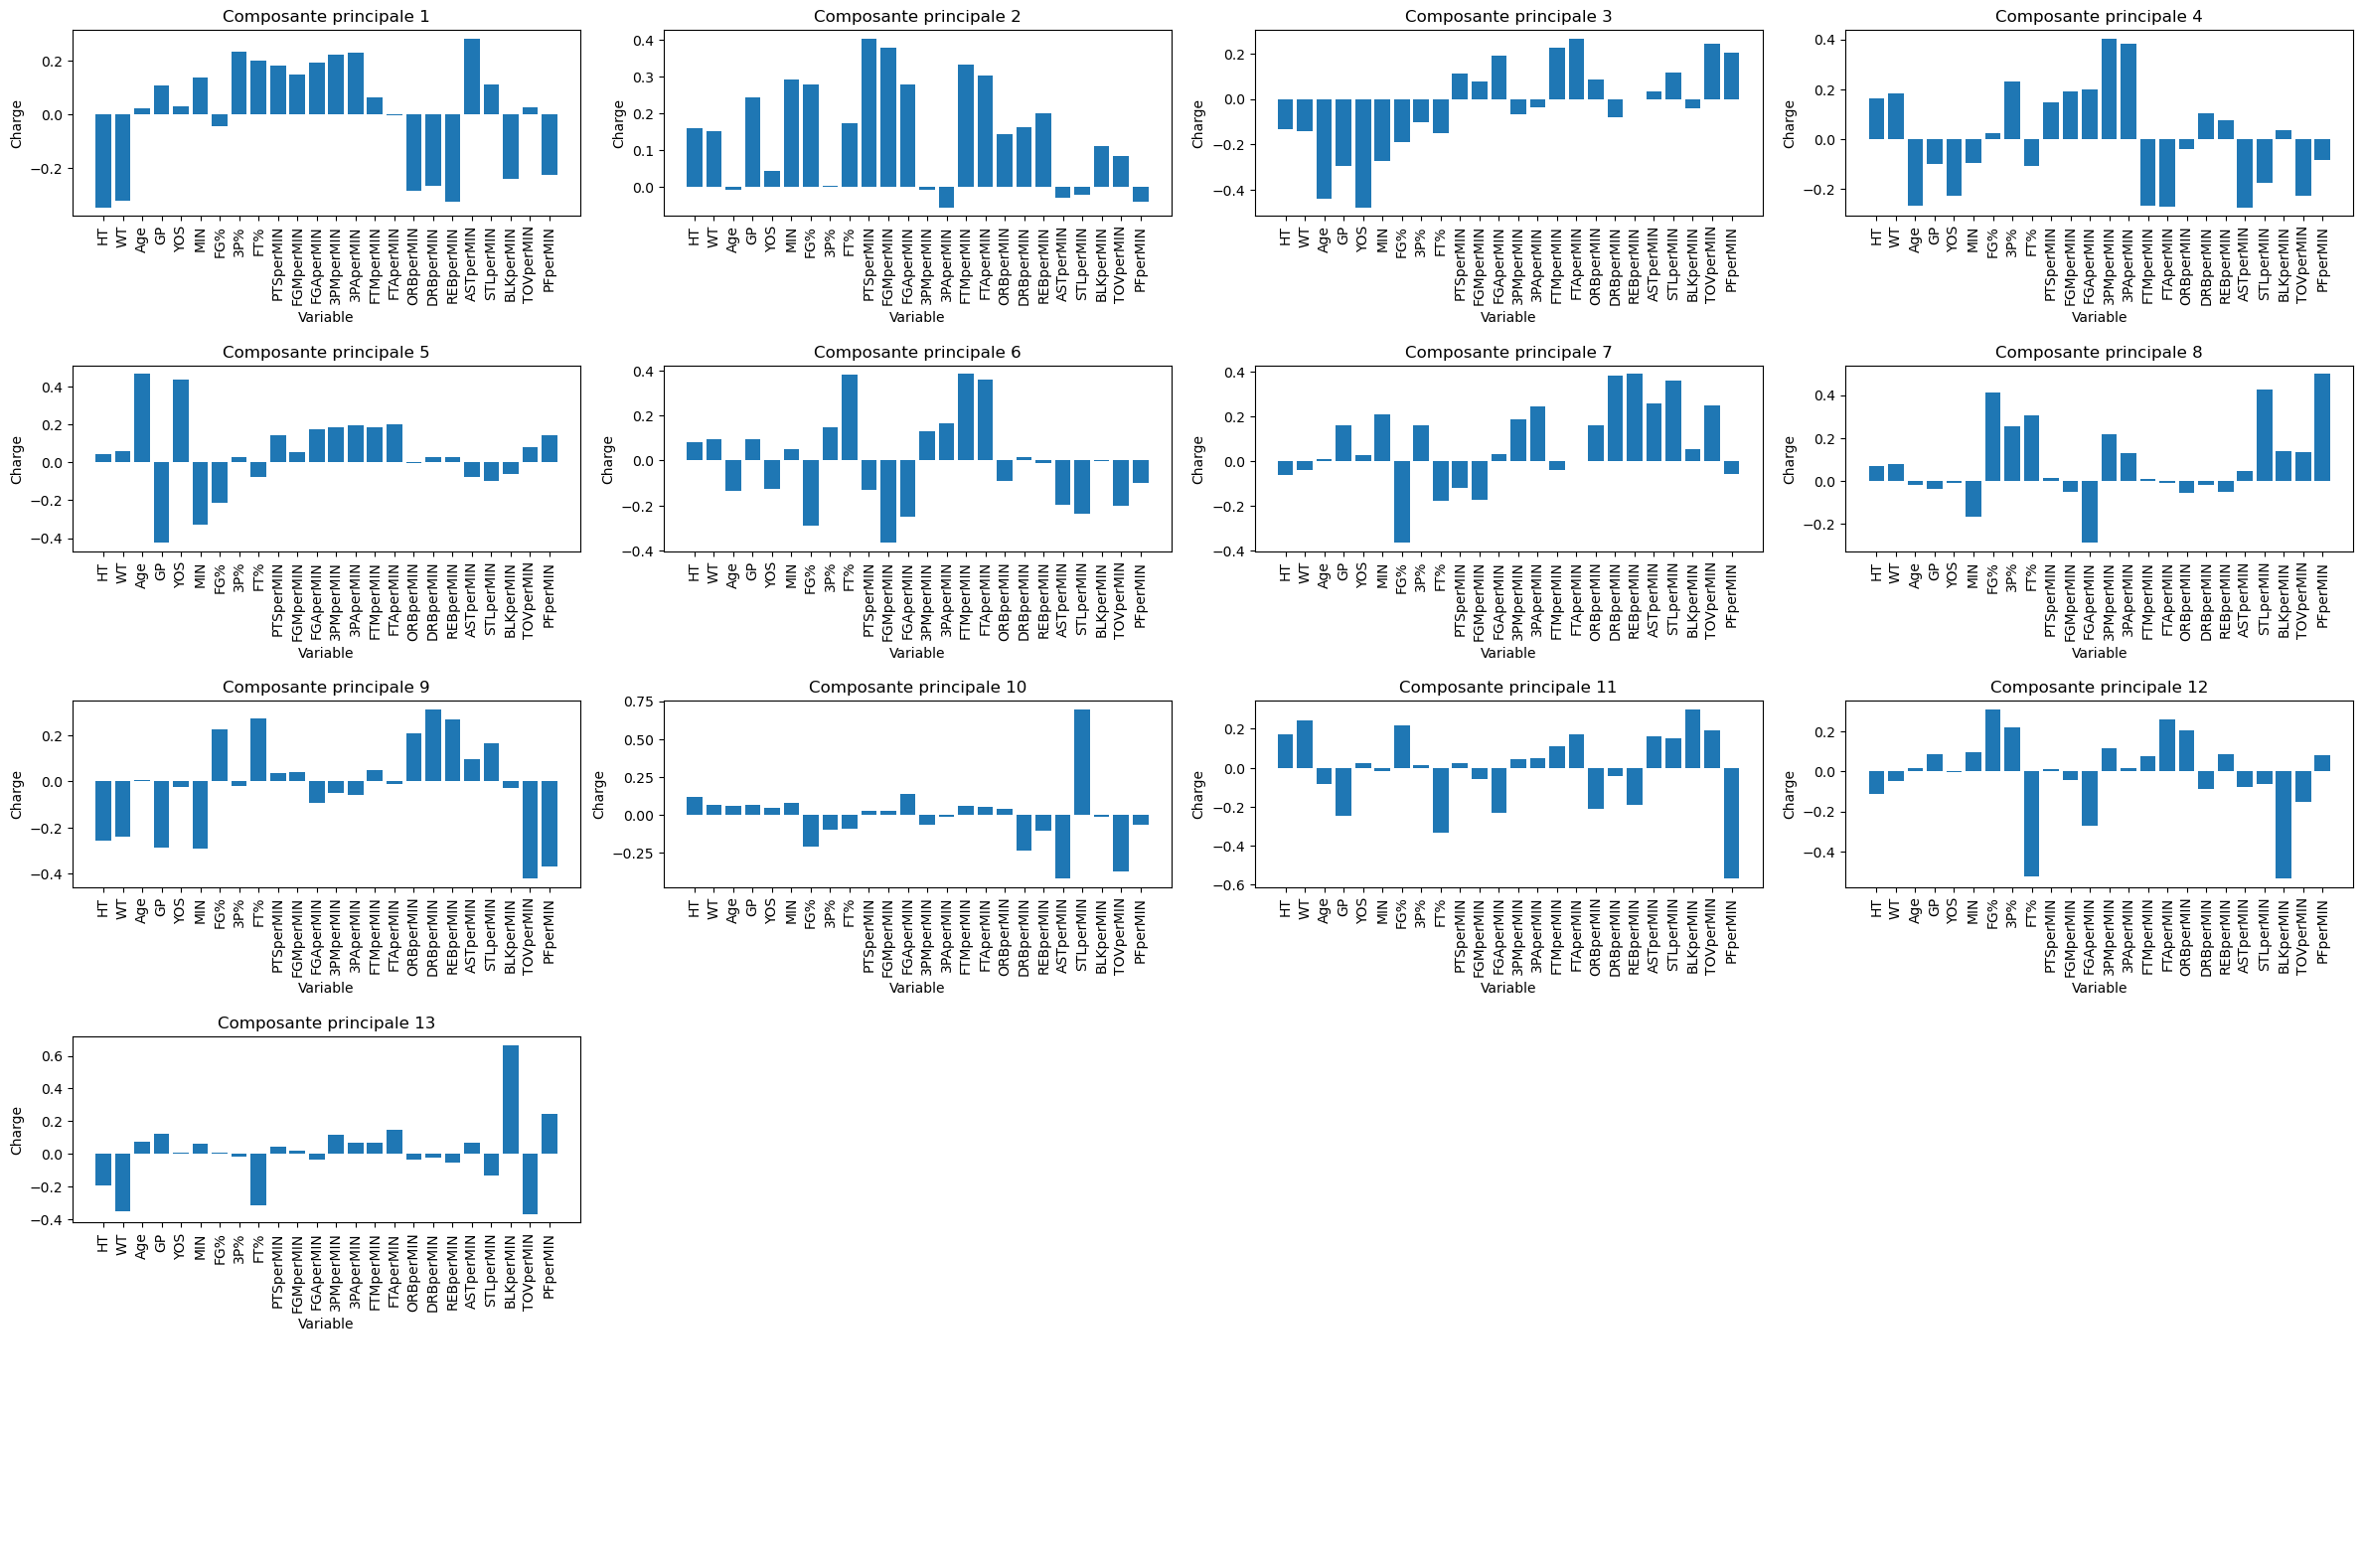

In [43]:
# Création de l'axe x pour le graphique en barres
x = np.arange(len(selected_df.columns))

# Déterminer le nombre de lignes et de colonnes pour la grille
num_rows =  5 # Nombre de lignes dans la grille
num_cols = (k + 1) // 3  # Nombre de colonnes dans la grille

# Création de la grille de sous-graphiques
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 16))

# Tracer le graphique en barres des charges des variables pour chaque composante principale
for i, ax in enumerate(axes.flatten()):
    if i < k:
        ax.bar(x, component_loadings[i])
        ax.set_xticks(x)
        ax.set_xticklabels(selected_df.columns, rotation='vertical')
        ax.set_xlabel('Variable')
        ax.set_ylabel('Charge')
        ax.set_title(f'Composante principale {i+1}')

    # Supprimer les axes des sous-graphiques non utilisés
    if i >= k:
        ax.axis('off')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout(pad=1.5)

# Afficher la grille de graphiques
plt.show()

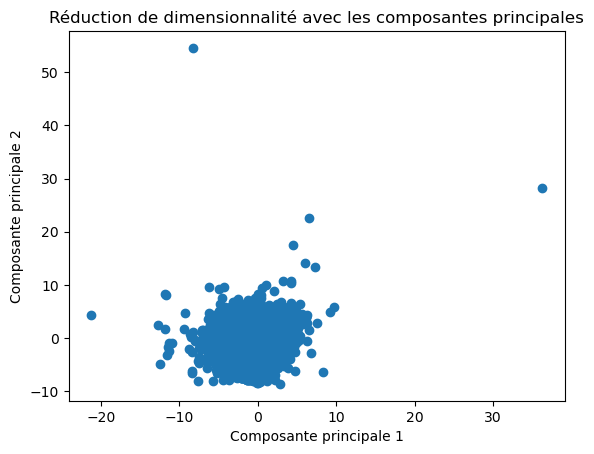

In [33]:
# Tracer le résultat de la réduction de dimensionnalité
plt.scatter(data_reduced[:, 0], data_reduced[:, 1])  # Tracer les deux premières composantes principales
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Réduction de dimensionnalité avec les composantes principales')
plt.show()